# RNN을 이용한 IMDB 영화평 분류

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
from tensorflow.keras.datasets import imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [3]:
X_train.shape, X_test.shape

((25000,), (25000,))

In [4]:
X_train[:3]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1

In [5]:
index_dict = {}
for key, value in imdb.get_word_index().items():
  index_dict[value] = key
len(index_dict)

88584

In [6]:
# 첫번째 영화평
' '.join(index_dict[s] for s in X_train[0])

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but wh

In [7]:
# 영화평의 길이
print('영화평의 최대 길이 :', max(len(l) for l in X_train))
print('영화평의 평균 길이 :', sum(map(len, X_train))/len(X_train))

영화평의 최대 길이 : 2494
영화평의 평균 길이 : 238.71364


In [8]:
unique_elements, counts_elements = \
    np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
label_cnt=dict(zip(unique_elements, counts_elements))
print(label_cnt)

각 레이블에 대한 빈도수:
{0: 12500, 1: 12500}


### Conv1D , LSTM으로 로이터 뉴스 분류
- 모든 단어가 아닌 빈도수 5000까지 (총 단어수 : 88,584)
- 모든 문장이아니라 500단어 까지 (최대 2,494 단어)

In [9]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.layers import Dropout, MaxPooling1D, Conv1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [10]:
# 등장 빈도가 5,000번째까지의 단어들만 사용
(X_train, y_train), (X_test, y_test) = \
    imdb.load_data(num_words=5000)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [11]:
X_train.shape, X_test.shape

((25000,), (25000,))

In [12]:
# 모델의 입력으로 사용하는 모든 뉴스 기사의 길이를 동일하게 500으로 맞춤
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

#### X_test의 10000개의 데이터를 검증셋으로, 나머지는 테스트셋으로


In [13]:
from sklearn.model_selection import train_test_split

X_val, X_test, y_val, y_test = \
    train_test_split(X_test, y_test, stratify=y_test, test_size=0.6, random_state=seed)

In [14]:
# 데이터 확인하기
category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 데이터 셋')
print(len(X_val), '검증용 데이터 셋')
print(len(X_test), '테스트용 데이터 셋')

2 카테고리
25000 학습용 데이터 셋
10000 검증용 데이터 셋
15000 테스트용 데이터 셋


In [16]:
# LSTM 모델
model = Sequential()
model.add(Embedding(5000, 120))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(60))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 120)         600000    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 120)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 60)                30000     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 668,525
Trainable params: 668,525
Non-trainable params: 0
________________________________________________

In [17]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [18]:
# Callback 함수 정의 - Best model, Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('model/imdb_best_model.h5', monitor='val_loss', 
                      verbose=1, save_best_only=True)

In [19]:
# 모델의 실행
history = model.fit(X_train, y_train, batch_size=200, epochs=50, 
                    validation_data=(X_val, y_val), verbose=2,
                    callbacks=[mc, es])

Epoch 1/50
125/125 - 10s - loss: 0.4598 - accuracy: 0.7709 - val_loss: 0.3345 - val_accuracy: 0.8550

Epoch 00001: val_loss improved from inf to 0.33446, saving model to model/imdb_best_model.h5
Epoch 2/50
125/125 - 7s - loss: 0.2470 - accuracy: 0.9023 - val_loss: 0.2706 - val_accuracy: 0.8887

Epoch 00002: val_loss improved from 0.33446 to 0.27055, saving model to model/imdb_best_model.h5
Epoch 3/50
125/125 - 7s - loss: 0.2039 - accuracy: 0.9234 - val_loss: 0.2946 - val_accuracy: 0.8803

Epoch 00003: val_loss did not improve from 0.27055
Epoch 4/50
125/125 - 7s - loss: 0.1777 - accuracy: 0.9330 - val_loss: 0.2827 - val_accuracy: 0.8864

Epoch 00004: val_loss did not improve from 0.27055
Epoch 5/50
125/125 - 7s - loss: 0.1501 - accuracy: 0.9439 - val_loss: 0.3103 - val_accuracy: 0.8839

Epoch 00005: val_loss did not improve from 0.27055
Epoch 6/50
125/125 - 7s - loss: 0.1285 - accuracy: 0.9536 - val_loss: 0.3140 - val_accuracy: 0.8853

Epoch 00006: val_loss did not improve from 0.27055

In [20]:
best_model = load_model('model/imdb_best_model.h5')

In [21]:
# 테스트 정확도
print(f"\n 테스트 정확도: {best_model.evaluate(X_test, y_test, verbose=2)[1]}")

469/469 - 2s - loss: 0.2755 - accuracy: 0.8821

 테스트 정확도: 0.8821333050727844


In [22]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

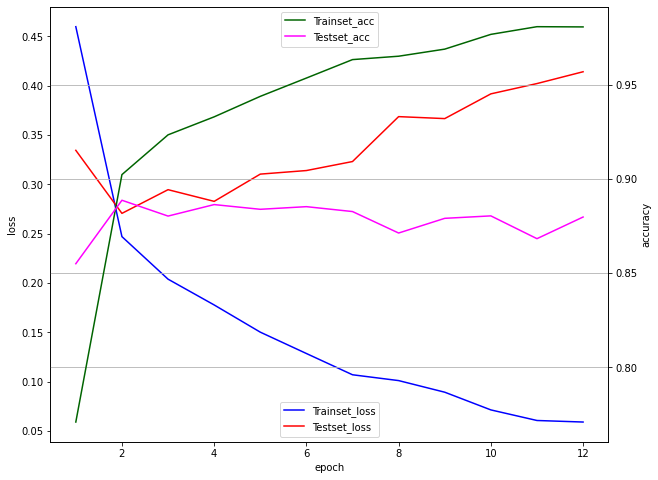

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Trainset_loss')
ax0.plot(x_len, y_vloss, c="red", label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()